In [1]:
# Load all route information using RouteLoader from dashboard/loaders/route_loader.py

import sys
import os

# Ensure dashboard directory is in sys.path for imports
dashboard_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dashboard'))
if dashboard_path not in sys.path:
    sys.path.insert(0, dashboard_path)

from loaders.route_loader import RouteLoader

# Path to the directory containing all route JSON files
route_data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'map_v2', 'all_rail_data'))

# Load all routes
route_loader = RouteLoader(route_data_dir)
all_routes = route_loader.load_all_routes()

print(f"Loaded {len(all_routes)} routes.")


Found 552 route files to process
Failed to parse progress.json
Successfully loaded 551 routes
Loaded 551 routes.


In [2]:
import json

# Path to the counties GeoJSON file (relative to this notebook)
counties_geojson_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'analytics', 'data', 'map', 'counties.geojson'))

import geopandas as gpd, json, pandas as pd
# read the file – GeoPandas will detect the native CRS
gdf = gpd.read_file(counties_geojson_path)
# convert to WGS‑84 so it lines up with lat/lon stations
gdf = gdf.to_crs("EPSG:4326")

# turn the re‑projected frame back into GeoJSON for Plotly
hungary_counties_geojson = json.loads(gdf.to_json())


print(f"Loaded Hungary counties GeoJSON with {len(hungary_counties_geojson.get('features', []))} features.")


Loaded Hungary counties GeoJSON with 20 features.


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path

# ──────────────────────────────────────────────────────────────
# 1.  Load the county polygons
# ──────────────────────────────────────────────────────────────
# If you already have the GeoDataFrame in memory, skip the read_file line.
gdf = gpd.read_file(Path("C:/Users/takat/OneDrive/Documents/Programming/fuck_lazar/analytics/data/map/counties.geojson"))

# • Check that every row has a geometry


stations_dict = route_loader.get_all_stations(all_routes)  # {station_id: Stop}

# build shapely Points; skip rows with missing coordinates
from shapely.geometry import Point
station_points  = []
station_names   = []        # optional, if you want hover or labels later

for stop in stations_dict.values():
    if stop.lat is not None and stop.lon is not None:
        station_points.append(Point(stop.lon, stop.lat))
        station_names.append(stop.name)



from shapely.ops import unary_union
from shapely.prepared import prep          # speeds up many repeated tests
from shapely.geometry import Point

# 1️⃣  Build a single polygon for the whole country
hungary_poly = unary_union(gdf.geometry)   # gdf is your counties GeoDataFrame
prepared_hungary = prep(hungary_poly)      # prepare once for fast look‑ups

# 2️⃣  Filter station list
valid_points  = []
valid_names   = []

for stop in stations_dict.values():        # stations_dict from RouteLoader
    if stop.lat is None or stop.lon is None:
        continue
    pt = Point(stop.lon, stop.lat)
    if prepared_hungary.contains(pt):      # or pt.within(hungary_poly)
        valid_points.append(pt)
        valid_names.append(stop.name)

# 3️⃣  Wrap into GeoDataFrame and plot
stations_gdf = gpd.GeoDataFrame(
    {"name": valid_names},
    geometry=valid_points,
    crs="EPSG:4326"
)


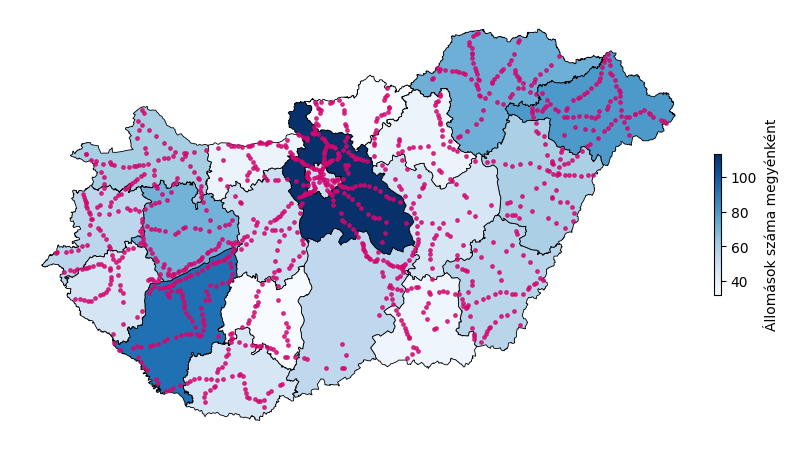

In [4]:
# ──────────────────────────────────────────────────────────────
# A)  Count how many stations fall inside each county
# ──────────────────────────────────────────────────────────────
import geopandas as gpd

# spatial join: tag every station with the county ("megye") it is inside
joined = gpd.sjoin(
    stations_gdf,                  # points
    gdf[["megye", "geometry"]],    # polygons (+ name)
    predicate="within",
    how="left"
)

# group & count
station_counts = (
    joined.groupby("megye")
          .size()                  # number of rows per county
          .rename("station_cnt")
          .reset_index()
)

# 🛠️  B)  make sure gdf has NO pre‑existing 'station_cnt' column
gdf = gdf.drop(columns=["station_cnt"], errors="ignore")

# C) merge and fill
gdf = (
    gdf.merge(station_counts, on="megye", how="left")
       .fillna({"station_cnt": 0})
)
gdf["station_cnt"] = gdf["station_cnt"].astype(int)

# ──────────────────────────────────────────────────────────────
# B)  Map: counties shaded by number of stations
# ──────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import os

fig, ax = plt.subplots(figsize=(8, 5))  # Make the country plot bigger

# choropleth layer (blue color theme)
gdf.plot(
    ax=ax,
    column="station_cnt",
    cmap="Blues",                  # blue sequential ramp
    legend=True,
    edgecolor="black",
    linewidth=0.6,
    legend_kwds={
        "label": "Állomások száma megyénként",
        "shrink": 0.3,             # Make the color bar smaller
        "fraction": 0.025,         # Make the color bar thinner
        "pad": 0.01
    }
)

# points layer (same as before)
stations_gdf.plot(
    ax=ax,
    markersize=6,
    color="#D3086F",
    alpha=0.8,
    label="Rail stations"
)

# tidy figure
ax.set_axis_off()
# ax.set_aspect("equal")
plt.tight_layout()

# Ensure the output directory exists
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/station_count_by_county.svg", format="svg")

plt.show()


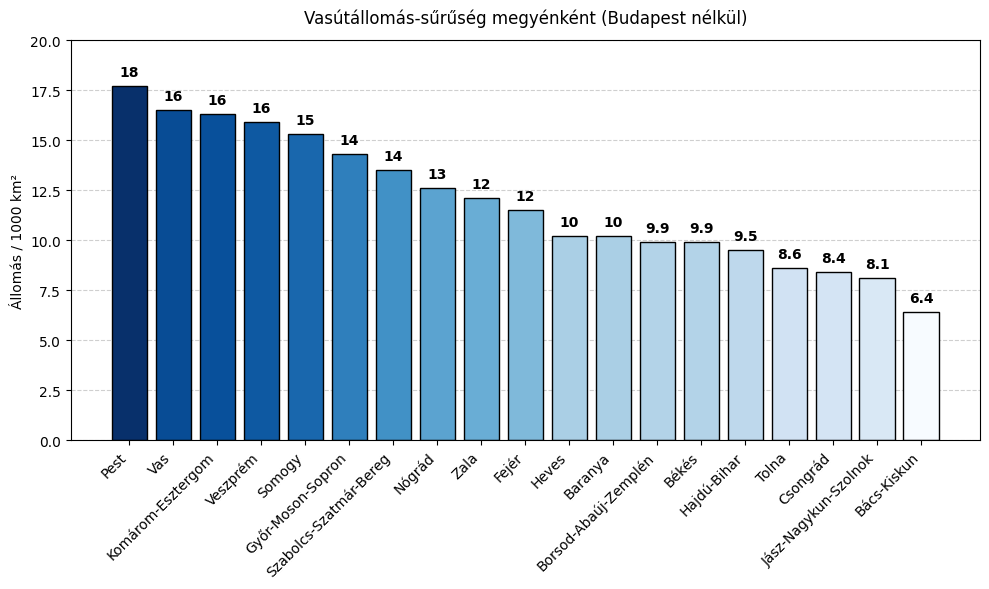

In [5]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import os

# ------------------------------------------------------------
# 1️⃣  Biztosítsuk, hogy minden megyének van area_km2 értéke
#     (vetületi átszámítás, ha szükséges)
# ------------------------------------------------------------
if "area_km2" not in gdf.columns:
    gdf_proj = gdf.to_crs("EPSG:23700")           # EOV / HD72, méter alapú
    gdf["area_km2"] = gdf_proj.area / 1_000_000   # m² ➔ km²

# ------------------------------------------------------------
# 2️⃣  Budapest eltávolítása (kilógó érték)
# ------------------------------------------------------------
gdf_hu = gdf[gdf["megye"] != "Budapest"].copy()

# ------------------------------------------------------------
# 3️⃣  Sűrűség számítása: állomás / 1000 km²
# ------------------------------------------------------------
gdf_hu["stations_per_1000km2"] = (
    gdf_hu["station_cnt"] / gdf_hu["area_km2"] * 1000
).round(1)

# ------------------------------------------------------------
# 4️⃣  Csökkenő sorrendbe rendezés
# ------------------------------------------------------------
gdf_sorted = gdf_hu.sort_values("stations_per_1000km2", ascending=False).reset_index(drop=True)

# ------------------------------------------------------------
# 5️⃣  Oszlopdiagram (Blues színskála, legsötétebb a legnagyobb értékhez)
#     Fekete vékony keret, fejterület a számoknak
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Blues színskála, legsötétebb a legnagyobb értékhez
cmap = plt.cm.Blues
norm = plt.Normalize(vmin=gdf_sorted["stations_per_1000km2"].min(), vmax=gdf_sorted["stations_per_1000km2"].max())
colors = [cmap(norm(val)) for val in gdf_sorted["stations_per_1000km2"]]

bars = ax.bar(
    gdf_sorted["megye"],
    gdf_sorted["stations_per_1000km2"],
    color=colors,
    edgecolor='black',
    linewidth=1
)

ax.set_title("Vasútállomás-sűrűség megyénként (Budapest nélkül)", pad=12)
ax.set_ylabel("Állomás / 1000 km²")
ax.set_xlabel("")  # X tengely felirat eltávolítása
plt.xticks(rotation=45, ha="right")

# Vízszintes, szaggatott rácsvonalak az x tengelyen
ax.yaxis.grid(True, linestyle='--', linewidth=0.8, alpha=0.6)
ax.set_axisbelow(True)

# Fejterület a számoknak
ymax = gdf_sorted["stations_per_1000km2"].max()
ax.set_ylim(0, ymax * 1.13)

# Értékek a sávok tetején, 1 jelentős jeggyel, NEM tudományos formátumban, fekete színnel
for bar, val in zip(bars, gdf_sorted["stations_per_1000km2"]):
    height = bar.get_height()
    # 1 jelentős jegy, de NEM tudományos formátum (pl. 8.2, 12, 5.7)
    if val < 10:
        label = f"{val:.1f}"
    else:
        label = f"{val:.0f}"
    ax.annotate(label,
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # 5 ponttal felfelé, hogy legyen fejterület
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

plt.tight_layout()

# Ensure the plots directory exists
os.makedirs("plots", exist_ok=True)
# Save as SVG
svg_path = os.path.join("plots", "station_density_by_county.svg")
plt.savefig(svg_path, format="svg")

plt.show()
